<a href="https://colab.research.google.com/github/jorferr89/10-ejemplos-opencv-python/blob/main/DeteccionPatenteVehiculo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detección de Patente en Vehiculo

In [ ]:
# Elimina mensajes de warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Librerías necesarias
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from local_utils import detect_lp
from os.path import splitext,basename
from keras.models import model_from_json

### Extracción de la patente de la imagen.

In [ ]:
def load_model(path):
    try:
        # Obtener el nombre del archivo sin la extensión
        path = splitext(path)[0]
        # Abrir el archivo JSON del modelo en modo lectura
        with open('%s.json' % path, 'r') as json_file:
            # Leer el contenido del archivo JSON
            model_json = json_file.read()
        # Crear un modelo de red neuronal a partir del JSON del modelo
        model = model_from_json(model_json, custom_objects={})
        # Cargar los pesos del modelo desde un archivo HDF5
        model.load_weights('%s.h5' % path)
        # Imprimir un mensaje de éxito
        print("Modelo cargado exitosamente...")
        # Devolver el modelo cargado
        return model
    except Exception as e:
        # Capturar cualquier excepción que ocurra durante el proceso de carga
        print(e)

In [ ]:
# Ruta al archivo JSON que contiene la arquitectura del modelo WPOD-NET
wpod_net_path = "wpod-net.json"
# Cargar el modelo WPOD-NET utilizando la función load_model
wpod_net = load_model(wpod_net_path)

Modelo cargado exitosamente...


1/1 [==============================] - 3s 3s/step


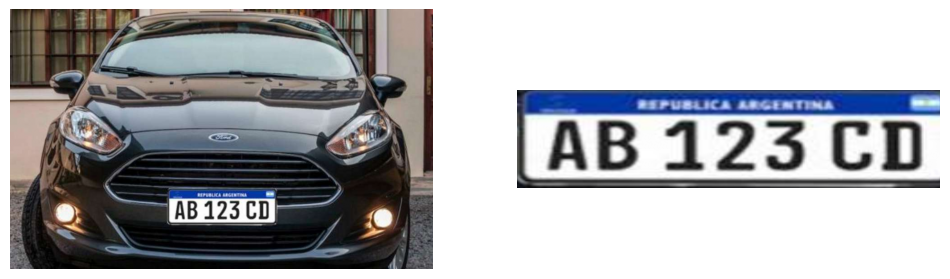

In [ ]:
# Función para preprocesar una imagen
def preprocess_image(image_path, resize=False):
    # Leer la imagen desde la ruta especificada
    img = cv2.imread(image_path)
    # Convertir la imagen de BGR a RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Normalizar los valores de píxeles para que estén en el rango [0, 1]
    img = img / 255
    # Redimensionar la imagen si el parámetro resize es True
    if resize:
        img = cv2.resize(img, (224,224))
    return img

# Función para obtener la matrícula de un vehículo en una imagen
def get_plate(image_path, Dmax=608, Dmin=608):
    # Preprocesar la imagen del vehículo
    vehicle = preprocess_image(image_path)
    # Calcular la relación entre el ancho y el alto de la imagen
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    # Calcular el tamaño del lado más largo según la relación y los valores Dmin y Dmax
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    # Detectar la matrícula en la imagen del vehículo utilizando el modelo WPOD-NET
    _, LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return vehicle, LpImg, cor

# Ruta de la imagen de prueba
test_image = "imagen-vehiculo-patente.jpg"
# Obtener la imagen del vehículo y la imagen de la matrícula
vehicle, LpImg, cor = get_plate(test_image)

# Mostrar la imagen original del vehículo y la imagen de la matrícula detectada
fig = plt.figure(figsize=(12,6))
grid = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
fig.add_subplot(grid[0])
plt.axis(False)
plt.imshow(vehicle)
grid = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
fig.add_subplot(grid[1])
plt.axis(False)
plt.imshow(LpImg[0])

### Segmentación de caracteres de la matrícula

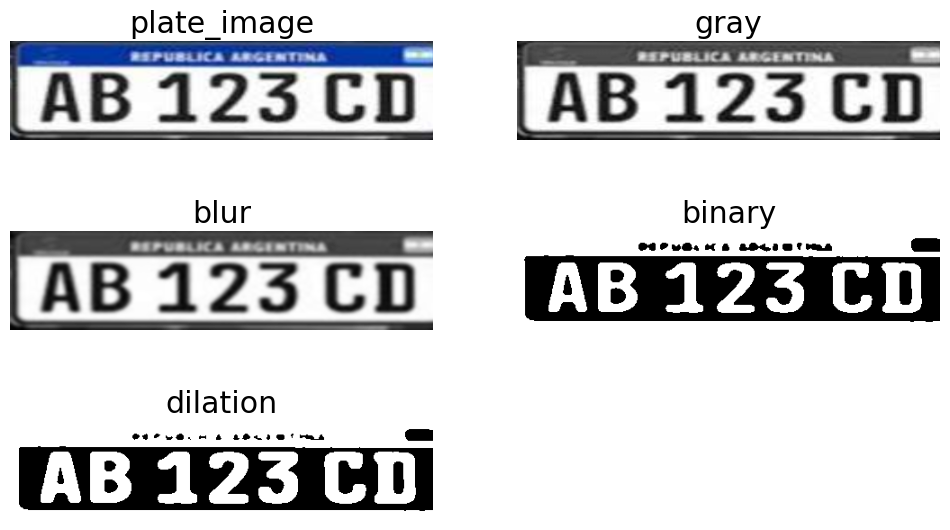

In [ ]:
if (len(LpImg)): # Verificar si hay al menos una imagen de matrícula
    # Escala, calcula valores absolutos y convierte el resultado a 8 bits.
    plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))

    # Convertir a escala de grises y desenfocar la imagen
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (7,7), 0)

    # Aplicar umbralización inversa binaria
    binary = cv2.threshold(blur, 180, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)

# Visualizar resultados
fig = plt.figure(figsize=(12,7))
plt.rcParams.update({"font.size":18})
grid = gridspec.GridSpec(ncols=2, nrows=3, figure=fig)
plot_image = [plate_image, gray, blur, binary, thre_mor]
plot_name = ["plate_image", "gray", "blur", "binary", "dilation"]

for i in range(len(plot_image)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.title(plot_name[i])
    if i == 0:
        plt.imshow(plot_image[i])
    else:
        plt.imshow(plot_image[i], cmap="gray")

Detectadas 7 letras...


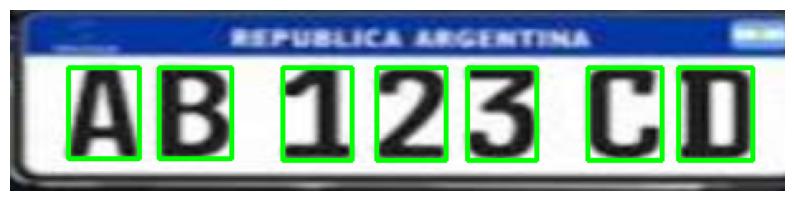

In [ ]:
# Crear la función sort_contours() para ordenar los contornos de cada dígito de izquierda a derecha
def sort_contours(cnts, axis='x', reverse=False):
    # Definir el índice basado en el eje especificado
    i = 0 if axis == 'x' else 1
    # Obtener los cuadros delimitadores de los contornos
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    # Ordenar los contornos basados en las coordenadas del cuadro delimitador
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes), key=lambda b: b[1][i], reverse=reverse))
    return cnts

# Encontrar contornos en la imagen binaria
cont, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Crear una copia de plate_image para dibujar los cuadros delimitadores
test_roi = plate_image.copy()

# Inicializar una lista para almacenar las imágenes de los caracteres
crop_characters = []

# Definir el ancho y alto estándar del carácter
digit_w, digit_h = 30, 60

# Recorrer los contornos y procesar cada uno
for c in sort_contours(cont, axis='x'):
    (x, y, w, h) = cv2.boundingRect(c)
    ratio = h / w
    if 1 <= ratio <= 3.5: # Seleccionar solo el contorno con la relación definida
        if h / plate_image.shape[0] >= 0.5: # Seleccionar el contorno que tiene una altura mayor al 50% de la placa
            # Dibujar un cuadro delimitador alrededor del número de dígito
            cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255, 0), 2)
            # Separar el número y dar una predicción
            curr_num = thre_mor[y:y+h, x:x+w]
            curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
            _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            crop_characters.append(curr_num)

print("Detectadas {} letras...".format(len(crop_characters)))

# Mostrar la imagen con los cuadros delimitadores
fig = plt.figure(figsize=(10, 6))
plt.axis(False)
plt.imshow(test_roi)
plt.show()

Referencia: https://github.com/quangnhat185/Plate_detect_and_recognize